In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns

import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from string import punctuation

### Data Collection and Summary

In [2]:
data = pd.read_csv("train.tsv", delimiter="\t")

In [3]:
data.shape

(1482535, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
data["item_condition_id"] = data["item_condition_id"].astype(str)
data["shipping"] = data["shipping"].astype(str)

In [6]:
data.drop_duplicates(subset=["name", "item_condition_id", "category_name", "brand_name", "price", "shipping"], inplace=True)

In [7]:
data.reset_index(drop= True, inplace = True)

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
train_id,1448099.0,736530.598540,428206.142467,0.0,364911.5,734177.0,1106937.5,1482534.0
price,1448099.0,26.910578,38.901796,0.0,10.0,17.0,30.0,2009.0


In [9]:
data.describe(include= "object").T

,count,unique,top,freq
name,1448099,1225273,Bundle,2126
item_condition_id,1448099,5,1,617688
category_name,1441791,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",58605
brand_name,832993,4809,Nike,52614
shipping,1448099,2,0,805274
item_description,1448095,1252966,No description yet,81913


### Missing Value Analysis

<AxesSubplot: >

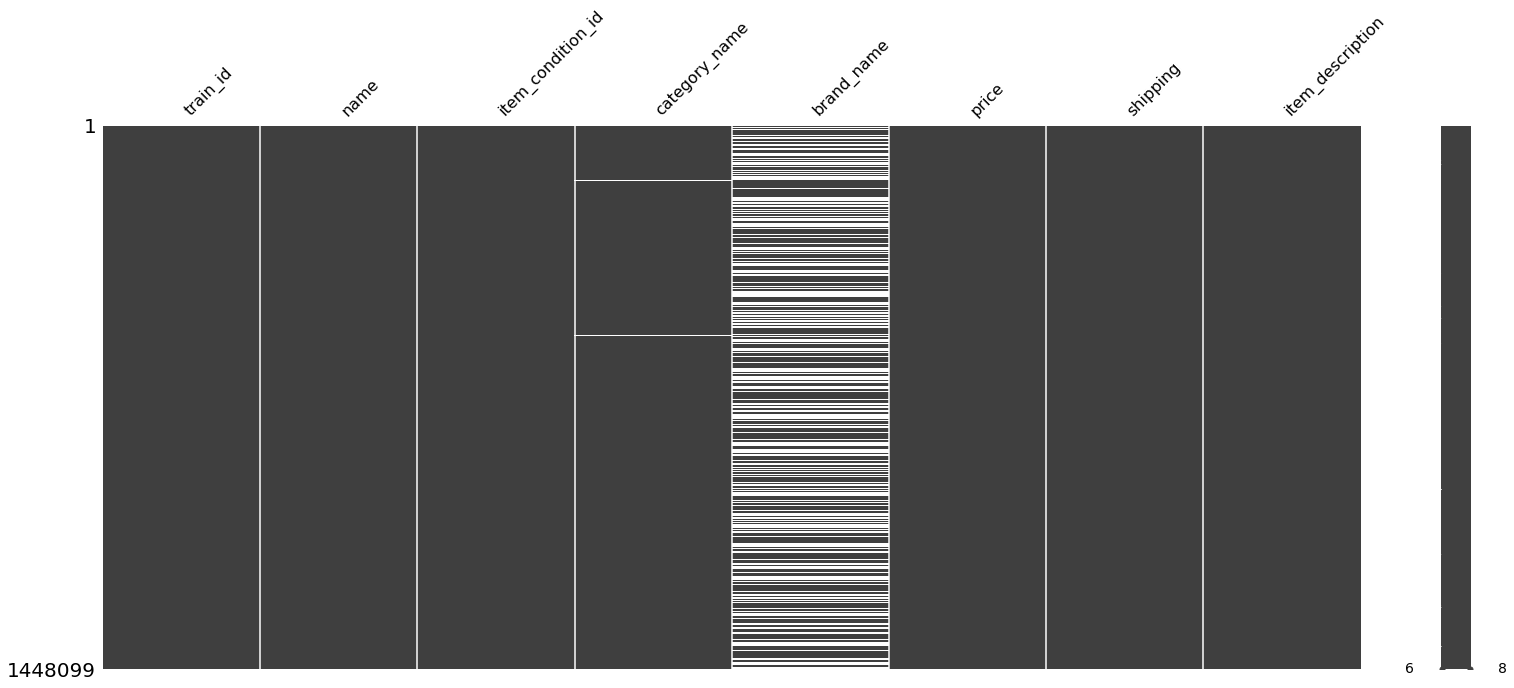

In [10]:
msno.matrix(data)

In [11]:
total_null = data.isnull().sum().sort_values(ascending = False)
percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending = False)
print("Total Records = ", data.shape[0])

missing_data = pd.concat([total_null,percent.round(2)],axis=1,keys=['Total Missing','In Percent'])
missing_data.head(10)

Total Records =  1448099


,Total Missing,In Percent
brand_name,615106,42.48
category_name,6308,0.44
item_description,4,0.00
train_id,0,0.00
name,0,0.00
item_condition_id,0,0.00
price,0,0.00
shipping,0,0.00


### Inference
- Brand name has 42.48% and category_name has 0.44 % missing values

### Data Visualization

#### Price 

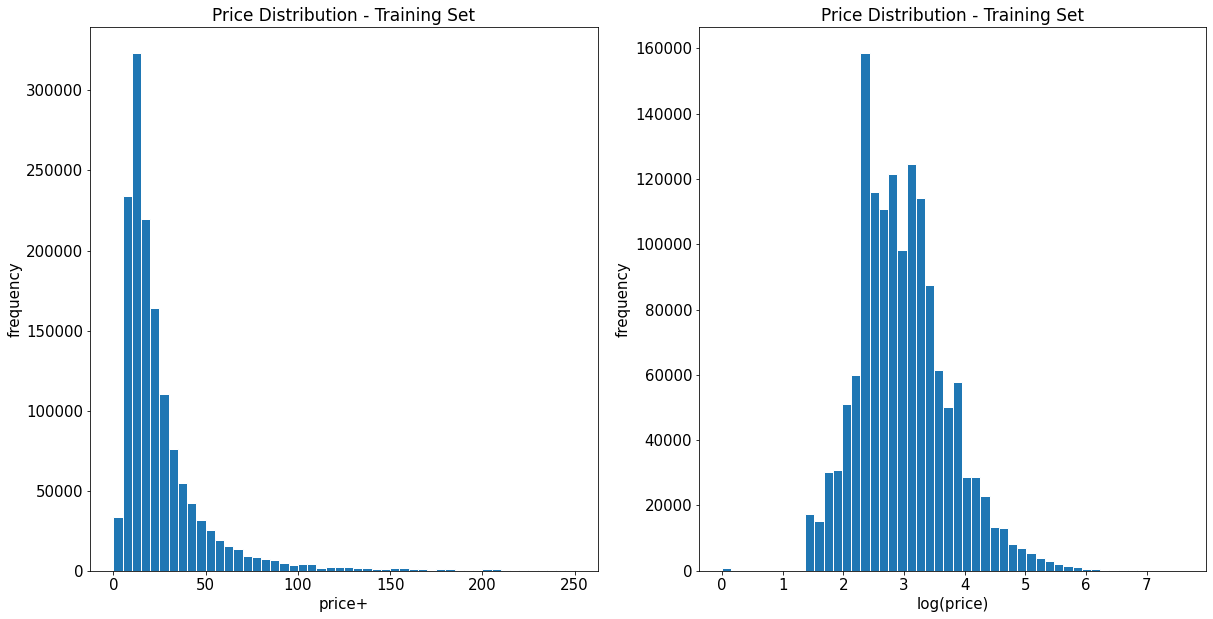

In [12]:
plt.subplot(1,2,1)
data["price"].plot.hist(bins=50, figsize = (20,10), edgecolor = "white", range = [0,250])
plt.xlabel("price+", fontsize = 15)
plt.ylabel("frequency", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.title("Price Distribution - Training Set", fontsize = 17)

plt.subplot(1,2,2)
np.log(data["price"]+1).plot.hist(bins=50, figsize = (20,10), edgecolor = "white")
plt.xlabel("log(price)", fontsize = 15)
plt.ylabel("frequency", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.title("Price Distribution - Training Set", fontsize = 17)
plt.show()

In [13]:
# Taking log of price values 
data["log_price"] = np.log10(data.loc[:, "price"]+1)

#### Price vs Item Condition

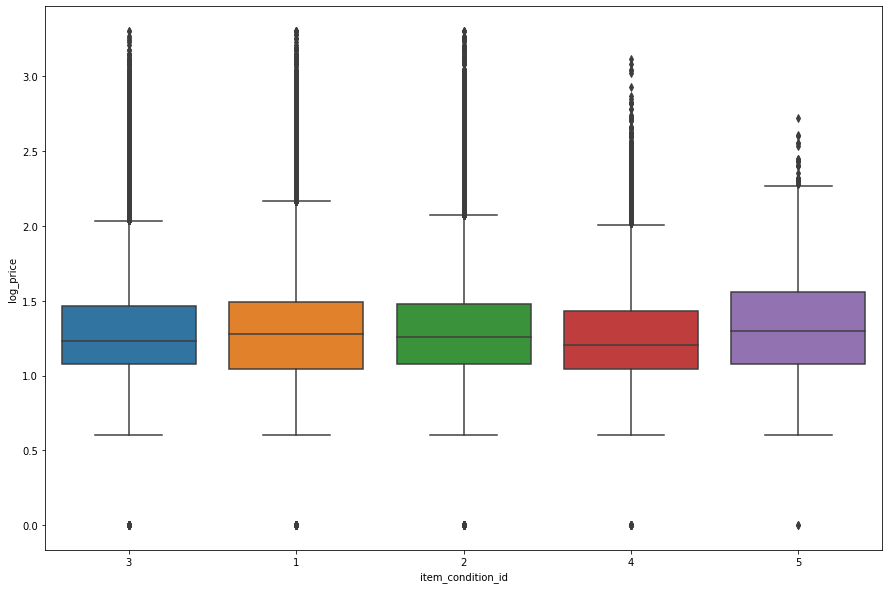

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot(data= data, x= "item_condition_id", y="log_price");

### Inference
- The median price across various item conditions is more or less same. 

##### Now, lets check if the item condition has an affect on price or not...### As no. of categories are more than 2, we will perform ANOVA TEST

In [15]:
data_item_cond1 = data.loc[data["item_condition_id"] == "1", :]
data_item_cond2 = data.loc[data["item_condition_id"] == "2", :]
data_item_cond3 = data.loc[data["item_condition_id"] == "3", :]
data_item_cond4 = data.loc[data["item_condition_id"] == "4", :]
data_item_cond5 = data.loc[data["item_condition_id"] == "5", :]

- H0 - The item condition has no affect on price 
- H1 - The item condition does has an affect on price 

In [16]:
from scipy import stats

In [17]:
F, p = stats.f_oneway(data_item_cond1["price"], data_item_cond2["price"], data_item_cond3["price"], data_item_cond4["price"], data_item_cond5["price"])

In [18]:
print("The p-value for the hypothesis that price for all the item conditions are same is", p, "Hence the Null Hypothesis is false")

The p-value for the hypothesis that price for all the item conditions are same is 1.2916533606440348e-70 Hence the Null Hypothesis is false


### Inference
- This means item condition does affect the price

#### Price vs Shipping Charge

In [19]:
data.shipping.value_counts(normalize=True)

# 0 - 55% of the customers bear the shipping charge 
# 1 - 45% of the sellers bear the shipping charge

0    0.55609
1    0.44391
Name: shipping, dtype: float64

In [20]:
# Lets see the distribution of price based on shipping type.
price_shipByBuyer = data.loc[data.shipping== "0", "price"]
price_shipBySeller = data.loc[data.shipping== "1", "price"]

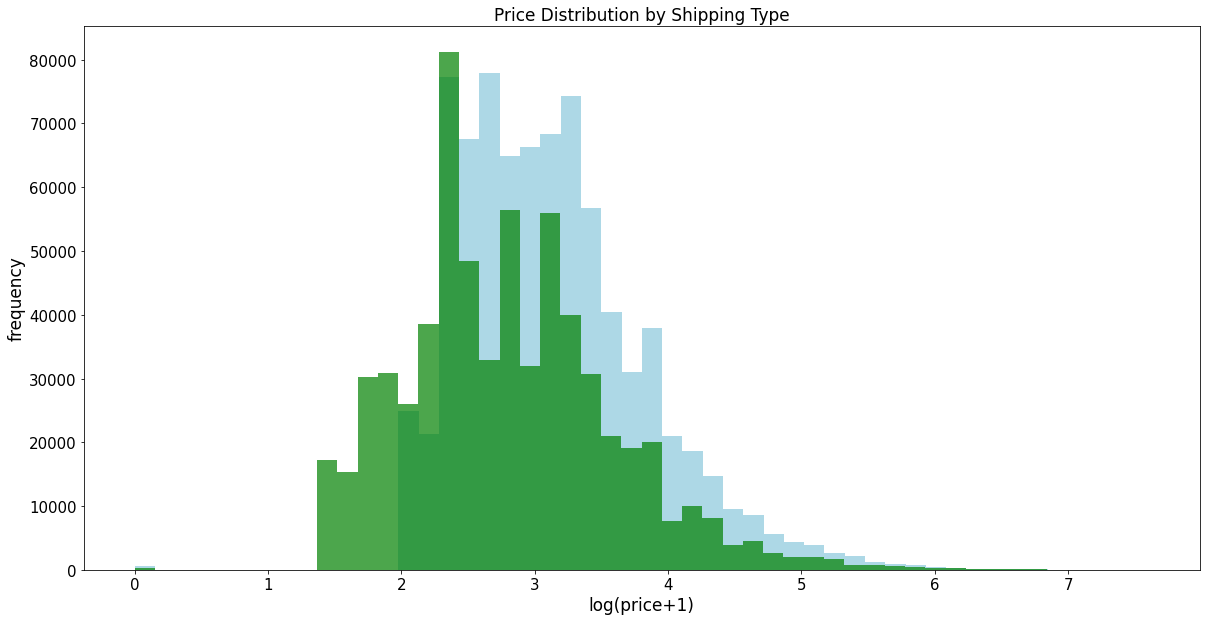

In [21]:
fig, ax = plt.subplots(figsize = (20,10))
ax.hist(np.log(price_shipByBuyer+1), color = "lightblue", bins = 50, alpha = 1, label = "Price when Buyer pays Shipping")
ax.hist(np.log(price_shipBySeller+1), color = "green", bins = 50, alpha = 0.7, label = "Price when Seller pays Shipping")
ax.set(title= "Histogram Comparison", ylabel="% of Dataset in Bin")
plt.xlabel("log(price+1)", fontsize = 17)
plt.ylabel("frequency", fontsize = 17)
plt.title("Price Distribution by Shipping Type", fontsize = 17)
plt.tick_params(labelsize = 15)
plt.show()

Now, lets check if shipping has an impact on item price or not...for this we will perform the **t-test**

In [22]:
stats.ttest_ind(price_shipBySeller, price_shipByBuyer, alternative= "less")

Ttest_indResult(statistic=-113.71865485031788, pvalue=0.0)

- H0 - the means of the distributions underlying the samples are equal
- H1 - the mean of price (shipped by seller) is less than mean of price (shipped by buyer)

### Inference 
- at 95% confidence interval, we can say that the mean of the price(shipped by seller) is less than mean of price (shipped by buyer)
- this means that costly products are mostly shipped by buyer's.

In [23]:
print("There are %d unique values in the category column." % data['category_name'].nunique())

There are 1287 unique values in the category column.


In [24]:
print("There are %d items that do not have a label." % data["category_name"].isnull().sum())

There are 6308 items that do not have a label.


### Analysis on category name

In [25]:
data["category_name"].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    58605
Women/Tops & Blouses/T-Shirts                     45648
Beauty/Makeup/Face                                33062
Beauty/Makeup/Lips                                28546
Electronics/Video Games & Consoles/Games          26298
Name: category_name, dtype: int64

In [26]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,1.041393
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1.724276
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1.041393
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,1.556303
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,1.653213


In [27]:
def split_category_name(df):
    try:
        return df.split("/")
    except:
        return ("NoLabel", "NoLabel", "NoLabel")

In [28]:
data["main_cat"], data["sub_cat1"], data["sub_cat2"] = zip(*data["category_name"].apply(lambda x:split_category_name(x)))

In [29]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,main_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,1.041393,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1.724276,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1.041393,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,1.556303,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,1.653213,Women,Jewelry,Necklaces


In [30]:
print("There are %d unique main categories." % data["main_cat"].nunique())

There are 11 unique main categories.


In [31]:
print("There are %d unique first subcategories." % data["sub_cat1"].nunique())

There are 114 unique first subcategories.


In [32]:
print("There are %d unique second subcategories." % data["sub_cat2"].nunique())

There are 871 unique second subcategories.


<AxesSubplot: xlabel='main_cat', ylabel='count'>

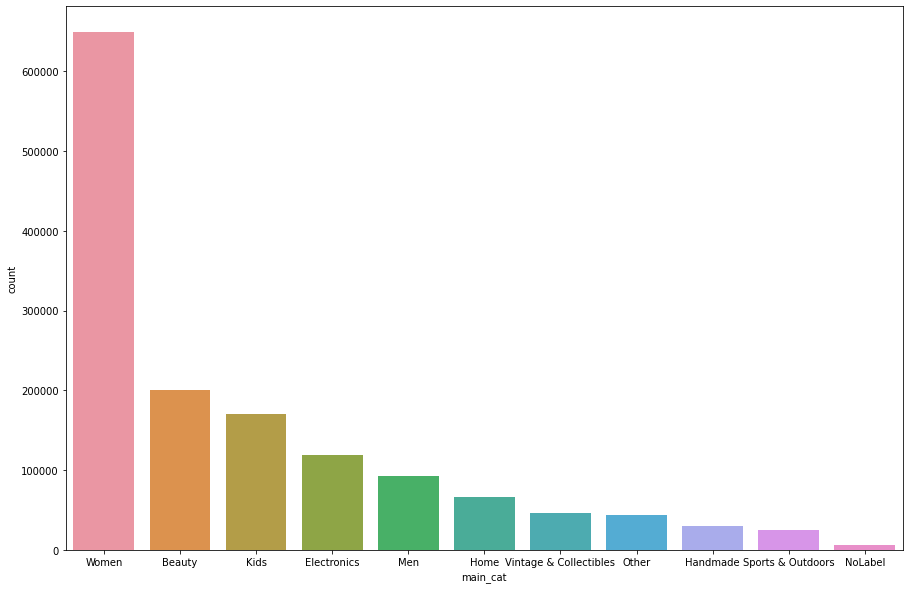

In [33]:
plt.figure(figsize=(15,10))
sns.countplot(data= data, x="main_cat", order= data.main_cat.value_counts().index)

<AxesSubplot: xlabel='log_price', ylabel='Density'>

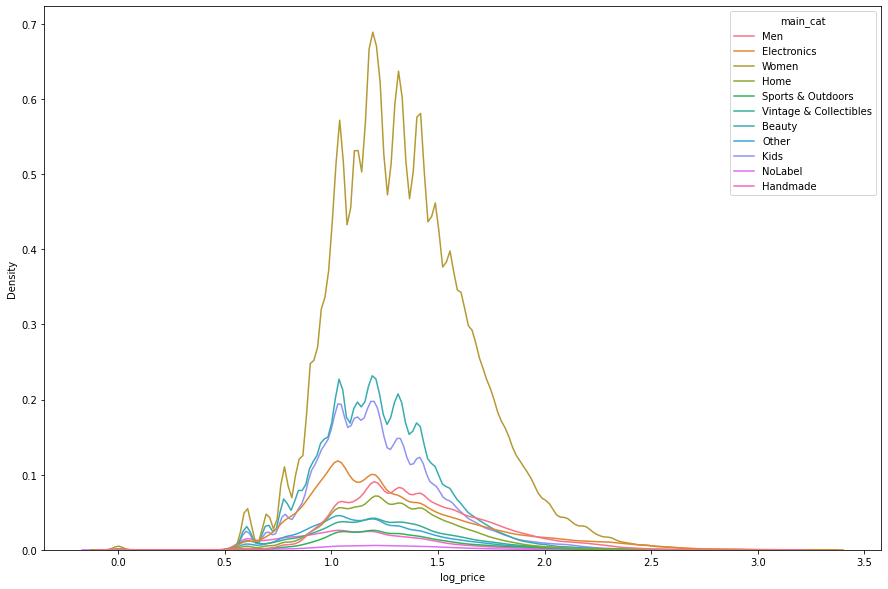

In [34]:
## Distribution plots of all these 11 categories
plt.figure(figsize=(15,10))
sns.kdeplot(data=data, x="log_price", hue = "main_cat")

<AxesSubplot: xlabel='log_price', ylabel='Density'>

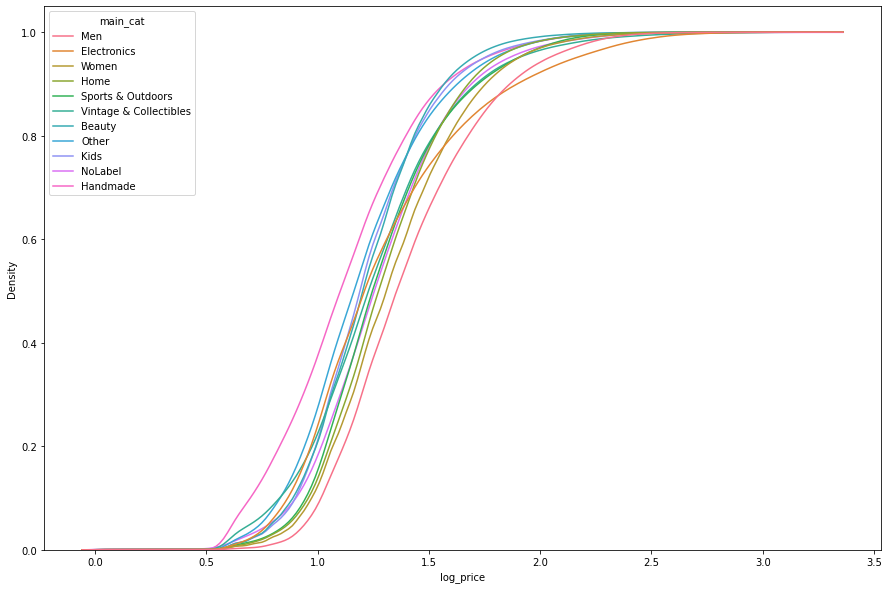

In [35]:
plt.figure(figsize=(15,10))
sns.kdeplot(data=data, x="log_price", hue = "main_cat", cumulative=True, common_norm=False, common_grid=True,)

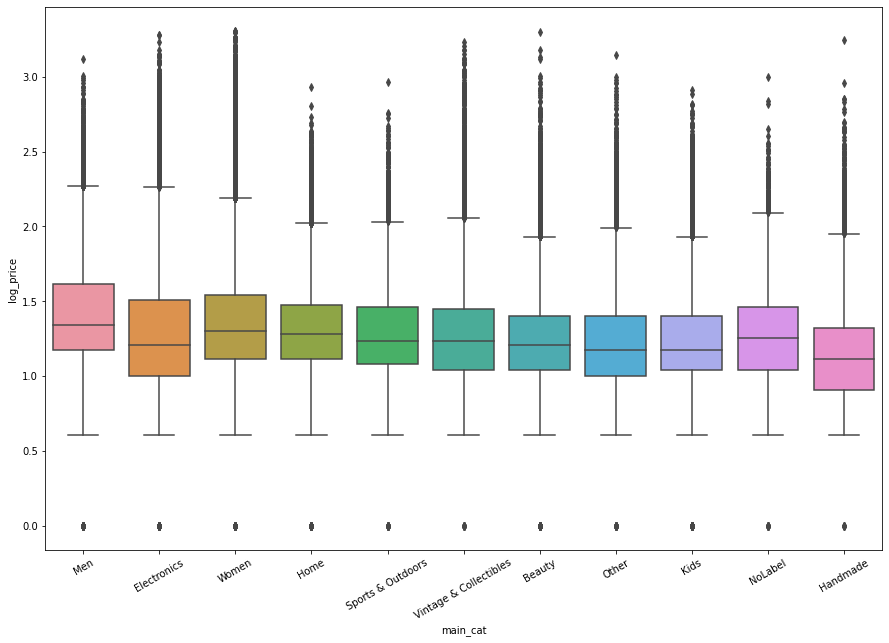

In [36]:
plt.figure(figsize=(15,10))
sns.boxplot(data= data, x= "main_cat", y="log_price");
plt.xticks(rotation = 30)
plt.show()

In [37]:
data.main_cat.value_counts()

Women                     648837
Beauty                    200469
Kids                      170287
Electronics               119068
Men                        92515
Home                       66298
Vintage & Collectibles     45987
Other                      43897
Handmade                   29586
Sports & Outdoors          24847
NoLabel                     6308
Name: main_cat, dtype: int64

In [38]:
Women = data.loc[data["main_cat"] == "Women", "price"]
Beauty = data.loc[data["main_cat"] == "Beauty", "price"]
Kids = data.loc[data["main_cat"] == "Kids", "price"]
Electronics = data.loc[data["main_cat"] == "Electronics", "price"]
Men = data.loc[data["main_cat"] == "Men", "price"]
Home = data.loc[data["main_cat"] == "Home", "price"]
Vintage_Collectibles = data.loc[data["main_cat"] == "Vintage & Collectibles", "price"]
Other = data.loc[data["main_cat"] == "Other", "price"]
Handmade = data.loc[data["main_cat"] == "Handmade", "price"]
Sports_Outdoors = data.loc[data["main_cat"] == "Sports & Outdoors", "price"]
NoLabel = data.loc[data["main_cat"] == "NoLabel", "price"]

In [39]:
F, p = stats.f_oneway(Women, Beauty, Kids, Electronics, Men, Home, Vintage_Collectibles, Other, Handmade, Sports_Outdoors, NoLabel)

In [40]:
print("The p-value for the hypothesis that price for all the categories are same is", p, "Hence the Null Hypothesis is false")

The p-value for the hypothesis that price for all the categories are same is 0.0 Hence the Null Hypothesis is false


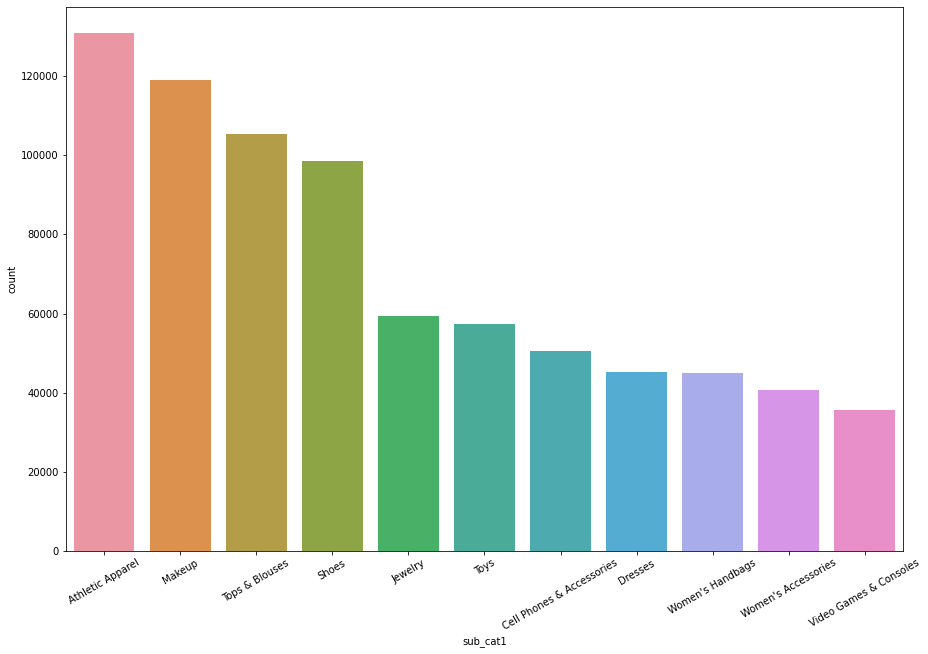

In [41]:
plt.figure(figsize=(15,10))
sns.countplot(data= data, x="sub_cat1", order= data.sub_cat1.value_counts().iloc[:11].index)
plt.xticks(rotation = 30)
plt.show()

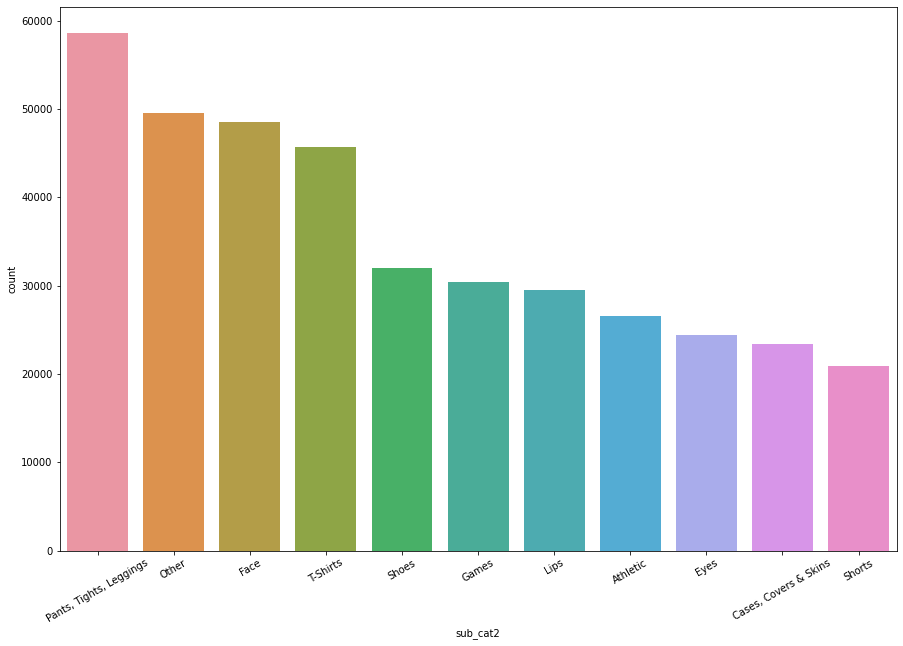

In [42]:
plt.figure(figsize=(15,10))
sns.countplot(data= data, x="sub_cat2", order= data.sub_cat2.value_counts().iloc[:11].index)
plt.xticks(rotation = 30)
plt.show()

##### Inference: 
- Most of the products are for ladies, with over 6 lakhs products  
- Under this category, most of the product sold Atheletics appareals like pants, tights and leggings or other makeup products
- Thats the reason, Beauty has next highest count after Women 

### Brand Name

In [43]:
print("There are %d unique brand names in training data." %data["brand_name"].nunique())

There are 4809 unique brand names in training data.


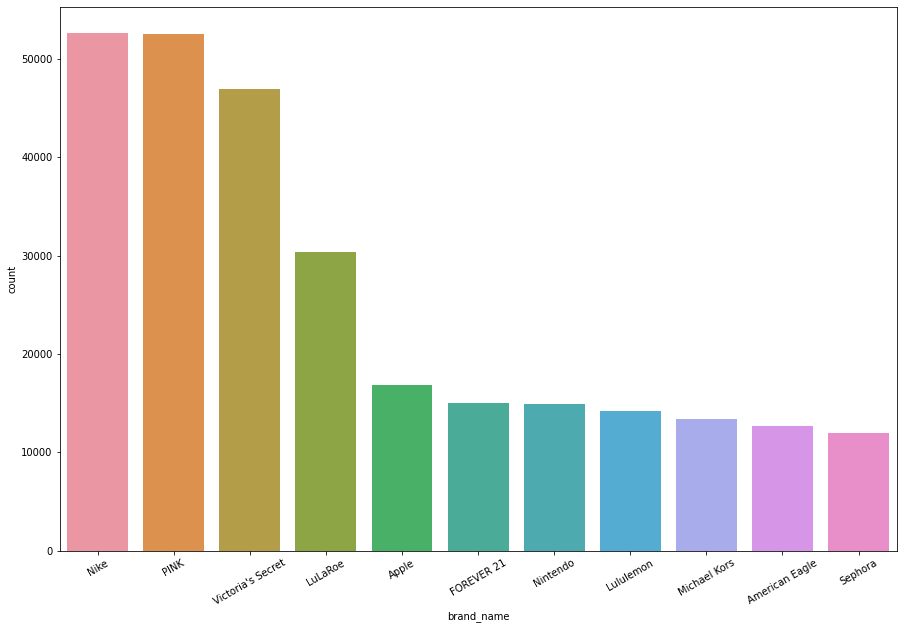

In [44]:
plt.figure(figsize=(15,10))
sns.countplot(data= data, x="brand_name", order= data.brand_name.value_counts().iloc[:11].index)
plt.xticks(rotation = 30)
plt.show()

##### Inference: 
- The 5 top brand names are PINK, Nike, Victoria's Secret, LuLaRoe and Apple

### Item Description

In [45]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,main_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,1.041393,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1.724276,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1.041393,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,1.556303,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,1.653213,Women,Jewelry,Necklaces


For item_description, 
- Lets do basic cleaning 
- Tokenizing 
- Removing Stop words 
- Generate the column with length of the description

In [46]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [47]:
data["clean_text"] = data["item_description"].map(tokenize)

nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object


- It shows that 4 rows do not have the item description defined 

In [48]:
data.item_description.isna().sum()

4

In [49]:
# Lets remove these 4 rows from our dataset

In [50]:
data.dropna(subset=["item_description"], inplace=True)

In [51]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,main_cat,sub_cat1,sub_cat2,clean_text
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,1.041393,Men,Tops,T-shirts,"[description, yet]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1.724276,Electronics,Computers & Tablets,Components & Parts,"[keyboard, great, condition, works, like, came..."
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1.041393,Women,Tops & Blouses,Blouse,"[adorable, top, hint, lace, key, hole, back, p..."
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,1.556303,Home,Home Décor,Home Décor Accents,"[new, tags, leather, horses, retail, stand, fo..."
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,1.653213,Women,Jewelry,Necklaces,"[complete, certificate, authenticity]"


In [52]:
data["ct_len"] = data["clean_text"].str.len()

In [53]:
data.item_condition_id.value_counts()

1    617688
3    425939
2    370323
4     31766
5      2379
Name: item_condition_id, dtype: int64

In [54]:
data.ct_len.value_counts()

2      143726
6       77061
4       76949
5       76111
7       73345
        ...  
146         4
149         3
150         1
145         1
147         1
Name: ct_len, Length: 150, dtype: int64

In [55]:
df = data.groupby("ct_len")["price"].mean().reset_index()

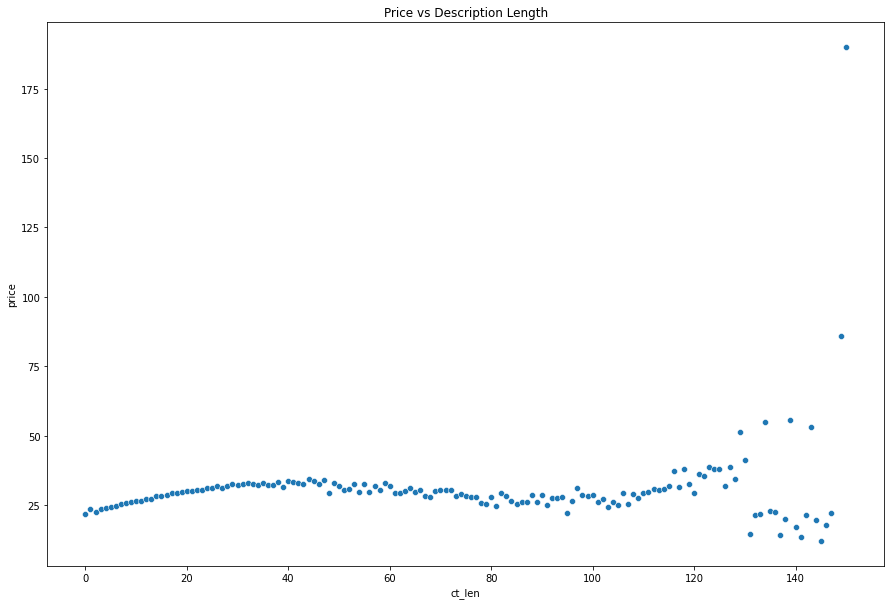

In [56]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x="ct_len", y="price")
plt.title("Price vs Description Length");

- The price doesn't vary much with the description length 

***Machine Learning algorithms cannot process raw text, as it needs to be converted into numbers first. We will be using the TFiDF method to vectorize the item description***

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

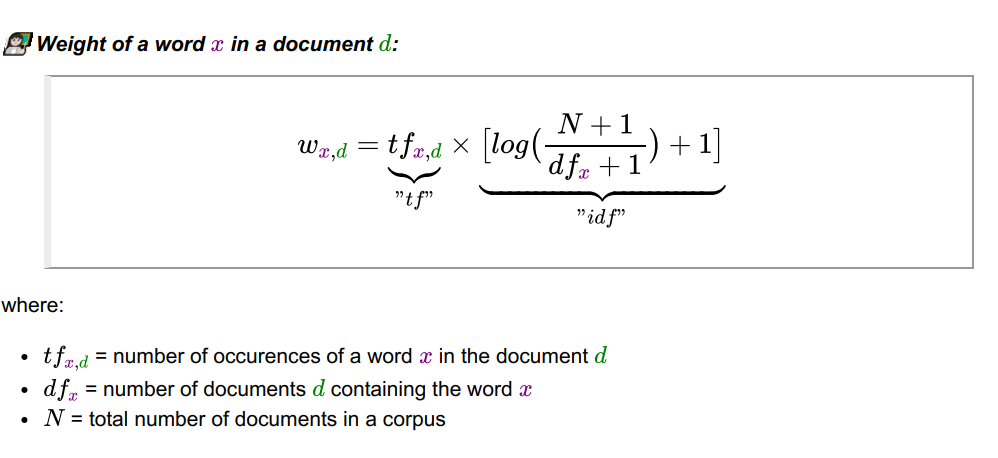

In [58]:
vectorizer = TfidfVectorizer(min_df= 11, max_features=15000, tokenizer= tokenize, ngram_range=(1,2))

In [59]:
viz = vectorizer.fit_transform(list(data.item_description.values))

c:\users\shussain55\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [60]:
tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ["tfidf"]

In [61]:
tfidf

,tfidf
aaa,8.588614
aaa batteries,9.206874
abalone,9.862750
abdomen,9.554548
abdominal,9.965404
...,...
❤️i,9.692699
❤️please,8.653426
❤️please contact,9.121975
➖prices,9.401935


##### Lets see some of the generic words we use to describe a product with lowest tfidf score. These words can't help us distinguishing one product from another and only used as connecting words

In [62]:
tfidf.sort_values(by=["tfidf"]).head(11)

,tfidf
new,2.183339
size,2.329894
brand,2.766905
condition,2.790659
brand new,2.888290
free,2.918268
shipping,3.092655
worn,3.097717
used,3.158103
never,3.271465


##### Lets see some of the special words we use to describe a product with the highest tfidf score. These words help us distinguishing one product from another and just by looking at them we can decide on the category (main) they belong to.


In [63]:
tfidf.sort_values(by=["tfidf"], ascending=False).head(11)

,tfidf
hidrocor,11.574842
shipping dollars,11.042625
low stock,10.951654
jordan jordan,10.909094
mini instax,10.909094
protector brandnew,10.816312
spoon pipes,10.803734
rba,10.791311
shipping candles,10.791311
shipped shipped,10.779041


Now, I would like to end this case study understanding the major topics around which the entire item description revolves around. For this we will make use of Latent Dirichlet Allocation,an unsupervised algorithm for finding topics in documents. 
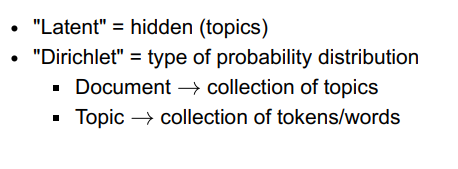

Lets take a sample of 21000 rows to have a broader understanding of the result

In [64]:
from sklearn.decomposition import LatentDirichletAllocation

In [65]:
sample_df = data.sample(n= 21000).reset_index(drop=True)

In [66]:
viz_2 = vectorizer.fit_transform(list(sample_df.item_description.values))

c:\users\shussain55\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [67]:
lda_model = LatentDirichletAllocation(n_components= 11, learning_method="online", max_iter= 21, random_state= 787)

##### Document Mixture (of Topics)

In [68]:
document_topic_mixture = lda_model.fit_transform(viz_2)

In [69]:
document_topic_mixture.shape

(21000, 11)

In [70]:
col = []
for i in range(11):
    col.append("topic_"+str(i))

In [71]:
col

['topic_0',
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4',
 'topic_5',
 'topic_6',
 'topic_7',
 'topic_8',
 'topic_9',
 'topic_10']

In [96]:
document_topic = pd.DataFrame(data=document_topic_mixture, index=sample_df.item_description, columns=col)
document_topic.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
item_description,,,,,,,,,,,
"Good condition like new,",0.233932,0.026133,0.026135,0.026133,0.026133,0.026133,0.026133,0.530865,0.026136,0.026133,0.026133
"Bundle of 9 girls 3t shorts and 2 skirts (with built in shorts inside). All are in EUC! Brands are Jumping Beans, Falls Creek, Old Navy, Circo and Cherokee.",0.019685,0.355769,0.252741,0.019669,0.019669,0.019669,0.019684,0.157947,0.019669,0.095824,0.019674
From The Target 2 Pack,0.037738,0.355525,0.037738,0.304825,0.037738,0.037738,0.037741,0.037738,0.037738,0.037738,0.037741
Brown and sequined and light brown and shiny studs. Both are super cute!!!!!,0.024732,0.144057,0.024739,0.024733,0.024734,0.024732,0.024732,0.024733,0.024733,0.633341,0.024733
"Lightweight jacket vailable in blue or black and in three sizes. This can fit smaller sizes as well, it's a bit oversized. Marked Nike for visibility. Please allow up to a week for this to ship out and up to four weeks for it to arrive to you. M - Length: 65cm/26inch Sleeve: 62cm/24.8inch Bust: 140cm/56inch L - Length: 66cm/26.4inch Sleeve: 63cm/25.2inch Bust: 144cm/57.6inch XL - Length: 67cm/26.8inch Sleeve: 64cm/25.6inch Bust: 148cm/59.2inch",0.020211,0.020211,0.207549,0.020211,0.020213,0.020211,0.042693,0.020211,0.020211,0.431275,0.177006


##### Topic Mixture (of Words)

In [73]:
topic_word_mixture = pd.DataFrame(lda_model.components_, columns = vectorizer.get_feature_names_out())

In [74]:
topic_word_mixture

,aaa,abercrombie,abercrombie fitch,abh,ability,able,absolutely,accent,accents,accept,...,•brand,•bundle,•bundle save,•no,•price,•size,❌no,❌no trades,❗️please,❤️please
0,0.090909,0.090929,0.090917,0.090909,0.090909,0.090936,0.090912,0.090914,0.090915,0.090910,...,1.630421,0.090911,0.090909,0.090913,0.090917,0.090912,3.062515,2.233230,0.090909,0.090909
1,0.090909,0.090915,0.090910,0.090909,0.090909,0.090910,0.090916,0.090909,0.090916,0.090913,...,0.090910,0.090909,0.090909,0.090910,0.090911,0.090916,0.090910,0.090910,0.090909,0.090911
2,0.090909,0.090921,0.090920,0.090909,0.090912,4.812971,0.090918,0.090920,0.090962,0.090913,...,0.090926,0.090934,0.090911,1.649337,2.948683,4.785306,0.090914,0.090922,0.090910,0.090909
3,0.090914,0.090912,0.090910,0.090909,0.090912,0.090952,0.090923,0.090911,0.090940,0.090909,...,0.090916,0.090914,0.090914,0.090914,0.090911,0.090931,0.090914,0.090951,0.090909,0.090911
4,0.090909,0.090910,0.090909,5.043773,0.090918,0.090918,0.090917,0.090957,0.090916,0.090917,...,0.090912,2.583791,2.350167,0.090912,0.091057,0.090909,0.090919,0.090917,0.090910,0.090911
5,0.090911,0.090910,0.090910,0.090914,0.090914,4.898204,0.090922,0.090911,0.090911,0.090910,...,0.090912,0.090914,0.090914,0.090921,0.090931,0.090909,0.090915,0.090952,0.090909,0.090909
6,0.090954,0.090911,0.090910,0.090910,0.090920,0.091042,0.090934,0.090953,5.755798,0.090917,...,0.090932,0.090914,0.090910,0.090915,0.091662,0.090918,0.090913,0.090920,0.090910,0.090910
7,4.436402,0.090933,0.090916,0.090909,0.090910,0.090927,0.090935,0.090914,0.090937,0.090912,...,0.090913,0.090927,0.090909,0.090913,0.090919,0.090920,0.090916,0.090931,0.090911,0.090909
8,0.090910,0.090909,0.090910,0.090912,0.090910,0.090915,0.090917,0.090911,0.090917,0.090913,...,0.090909,0.090909,0.090909,0.090909,0.090909,0.090910,0.090912,0.090910,0.090909,0.090909
9,0.090922,11.240031,5.408568,0.090910,0.090913,0.090952,13.090479,6.576421,0.090937,0.090914,...,1.638946,0.090915,0.090912,0.090917,0.090962,0.090946,4.481333,0.090996,2.235164,0.090913


##### Lets see what are the three most relevant words for each topic?

In [75]:
def print_topics(lda_model, vectorizer, top_words):
    topic_mixture = pd.DataFrame(lda_model.components_, columns = vectorizer.get_feature_names_out())
    
    n_components = topic_mixture.shape[0]
    
    for topic in range(n_components):
        print("-"*121)
        print(f"For topic {topic}, here are the top {top_words} words with weights:")
        
        topic_df = topic_mixture.iloc[topic].sort_values(ascending = False).head(top_words)
        
        print(round(topic_df, 3))

In [76]:
print_topics(lda_model, vectorizer, 3)

-------------------------------------------------------------------------------------------------------------------------
For topic 0, here are the top 3 words with weights:
condition         148.178
good              122.133
good condition    103.498
Name: 0, dtype: float64
-------------------------------------------------------------------------------------------------------------------------
For topic 1, here are the top 3 words with weights:
description yet    677.791
yet                677.462
description        665.308
Name: 1, dtype: float64
-------------------------------------------------------------------------------------------------------------------------
For topic 2, here are the top 3 words with weights:
size         443.281
condition    287.528
worn         223.880
Name: 2, dtype: float64
-------------------------------------------------------------------------------------------------------------------------
For topic 3, here are the top 3 words with weights:
new       

In [97]:
document_topic.reset_index(inplace=True)
document_topic["highest_topic"] = document_topic[['topic_0', 'topic_1', 'topic_2', 'topic_3','topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9','topic_10']].idxmax(axis=1)
merge_df = pd.merge(sample_df, document_topic[["item_description", "highest_topic"]], on="item_description")

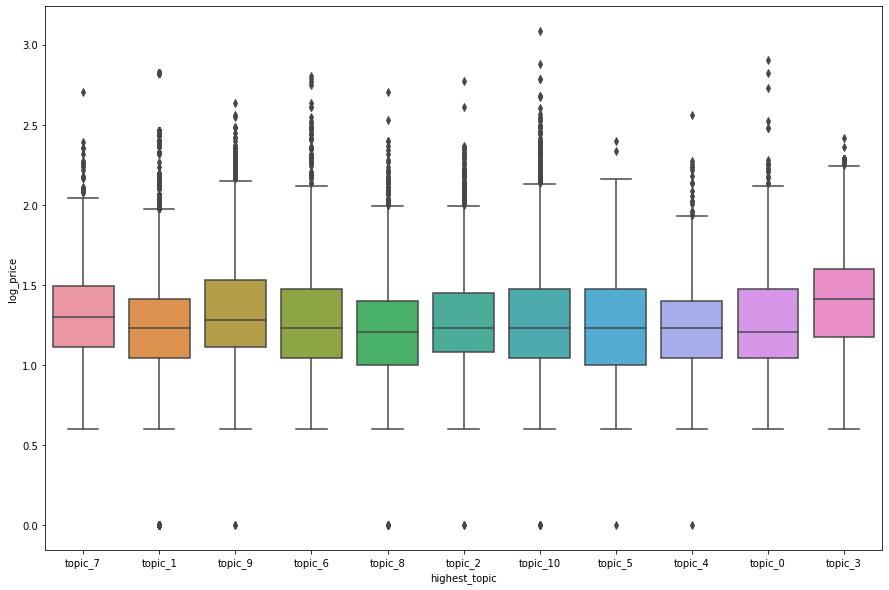

In [103]:
plt.figure(figsize=(15,10))
sns.boxplot(data= merge_df, x="highest_topic", y="log_price");

In [109]:
merge_df.loc[merge_df["highest_topic"]=="topic_3", "price"].median()

25.0

##### Inference 
- It can be seen from the above plot that log_price for topic_3 has the highest median value of 25 USD which contains the words such as new, lularoe and leggings.

##### Here we end the work over this case study. 

A big thanks to 

<div>
    <h1 style="color:blue;"align="center"> SCALER </h1> 
</div>

for letting me work on this. 